# Qualche grafico da visualizzare

Analizziamo dei dati di AREU per cavarne un ragno dal buco. I dati sono disponibili pubblicamente sul [sito di AREU](https://www.areu.lombardia.it/web/home/missioni-aat-real-time). I dati storici sono stati ottenuti con un piccolo [script python](https://github.com/r-carissimi/areu-data-collector).
AREU è l'Agenzia Regionale Emergenza Urgenza, ovvero l'ente di Regione Lombardia che ha il compito di gestire, tra le altre cose, le chiamate al Numero Unico di Emergenza 112. Di fatto questi dati rappresentano le _missioni_ (ovvero gli interventi) riguardo al **soccorso sanitario in provincia di Milano**.

In [64]:
import matplotlib.pyplot as plt 
import pandas as pd
from datetime import datetime, timedelta

#Configurazioni globali di Matplotlib
%matplotlib inline
plt.style.use('bmh')
plt.rc('figure', figsize=(10.0, 10.0))

#Leggiamo il CSV
df = pd.read_csv('data/milano.csv')

In [67]:
#Copio il dataframe
data = df

#Creo delle colonne per analizzare meglio il tempo
time = df["aggiornato_alle"] + " " + df["day_data"]
data["timestamp"] = time.apply(lambda x: datetime.strptime(x, '%H:%M %d/%m/%Y'))
data["weekday"] = data["timestamp"].apply(lambda x: x.strftime("%w"))
data["hour"] = data["timestamp"].apply(lambda x: x.strftime("%H"))
data["month"] = data["timestamp"].apply(lambda x: x.strftime("%m"))

#Seleziono solo le colonne che mi interessano
data = data.drop(["aat", "soreu", "aggiornato_alle", "day_data"], axis=1)
data = data.set_index("timestamp")
data

,msb,msi,msa,elisoccorso,soccorso_alpino,soccorso_acqua,missioni,rosso,giallo,verde,...,trasporto_organi,trasporto_prenotato,prestazione_ambulatoriale,da_richiamare,mezzi_altro,altro,totale_traffico_tel,weekday,hour,month
timestamp,,,,,,,,,,,,,,,,,,,,,
2022-03-09 17:40:00,75,0,5,0,0,0,80,10,48,22,...,2,0,0,0,0,0,71,3,17,03
2022-03-09 18:23:00,83,0,3,0,0,0,86,7,62,17,...,2,0,0,0,0,0,80,3,18,03
2022-03-09 18:26:00,82,0,2,0,0,0,84,7,60,17,...,2,0,0,0,0,0,78,3,18,03
2022-03-09 18:31:00,82,0,2,0,0,0,85,7,61,16,...,2,0,0,0,1,0,79,3,18,03
2022-03-09 18:33:00,80,0,2,0,0,0,83,7,59,16,...,2,0,0,0,1,0,76,3,18,03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-05 16:41:00,80,2,3,0,0,0,85,7,52,26,...,0,0,0,0,0,0,80,2,16,04
2022-04-05 16:45:00,76,2,3,0,0,0,81,7,49,25,...,0,0,0,0,0,0,76,2,16,04
2022-04-05 16:49:00,80,2,3,0,0,0,85,7,53,25,...,0,0,0,0,0,0,80,2,16,04


## Media di ambulanze per ogni giorno della settimana

Ora analizziamo la media delle ambulanze per ogni giorno della settimana, separando le statistiche per turno.

In [151]:
def turno(timestamp):
	weekday = timestamp.strftime("%u (%A)")
	hour = int(timestamp.strftime("%H"))
	if 0 <= hour < 8 : 
		hour = "4 (Night)"
		weekday = (timestamp-timedelta(days=1)).strftime("%u (%A)")
	elif 8 <= hour < 13 : hour = "1 (Morning)"
	elif 13 <= hour < 19 : hour = "2 (Afternoon)"
	elif 19 <= hour < 24 : hour = "3 (Evening)"
	return weekday + " " + hour

medie = data.groupby(by = turno).mean()
std = data.groupby(by = turno).std()
medie

,msb,msi,msa,elisoccorso,soccorso_alpino,soccorso_acqua,missioni,rosso,giallo,verde,...,guardia_medica,informazioni,consulenza,trasporto_organi,trasporto_prenotato,prestazione_ambulatoriale,da_richiamare,mezzi_altro,altro,totale_traffico_tel
timestamp,,,,,,,,,,,,,,,,,,,,,
1 (Monday) 1 (Morning),77.887283,0.520231,2.190751,0.095376,0.0,0.0,80.765896,5.413295,49.303468,26.043353,...,0.0,0.00000,0.000000,0.757225,0.0,0.0,0.0,0.072254,0.000000,75.939306
1 (Monday) 2 (Afternoon),84.338501,0.837209,2.470284,0.118863,0.0,0.0,87.989664,5.609819,52.072351,30.299742,...,0.0,0.00000,0.000000,1.356589,0.0,0.0,0.0,0.224806,0.000000,81.198966
1 (Monday) 3 (Evening),69.341060,0.748344,3.453642,0.132450,0.0,0.0,73.847682,5.715232,44.387417,23.672185,...,0.0,0.00000,0.000000,0.933775,0.0,0.0,0.0,0.172185,0.000000,67.165563
1 (Monday) 4 (Night),26.242938,0.327684,1.418079,0.000000,0.0,0.0,27.960452,2.398305,16.488701,9.098870,...,0.0,0.00000,0.000000,0.225989,0.0,0.0,0.0,0.000000,0.000000,25.621469
2 (Tuesday) 1 (Morning),81.223464,1.351955,3.759777,0.262570,0.0,0.0,86.684358,10.245810,53.586592,22.762570,...,0.0,0.00000,0.002793,0.365922,0.0,0.0,0.0,0.086592,0.000000,77.810056
2 (Tuesday) 2 (Afternoon),86.301587,2.161376,3.386243,0.402116,0.0,0.0,92.330688,8.708995,57.404762,26.179894,...,0.0,0.00000,0.000000,0.703704,0.0,0.0,0.0,0.079365,0.000000,83.865079
2 (Tuesday) 3 (Evening),64.141553,1.287671,2.515982,0.082192,0.0,0.0,68.027397,6.232877,40.689498,21.100457,...,0.0,0.00000,0.000000,0.164384,0.0,0.0,0.0,0.000000,0.000000,62.305936
2 (Tuesday) 4 (Night),26.528517,0.365019,1.053232,0.000000,0.0,0.0,27.946768,2.581749,14.939163,10.425856,...,0.0,0.00000,0.000000,0.414449,0.0,0.0,0.0,0.000000,0.000000,26.072243
3 (Wednesday) 1 (Morning),77.590517,0.706897,1.939655,0.375000,0.0,0.0,80.715517,8.349138,51.491379,20.866379,...,0.0,0.00431,0.000000,0.288793,0.0,0.0,0.0,0.103448,0.000000,75.314655


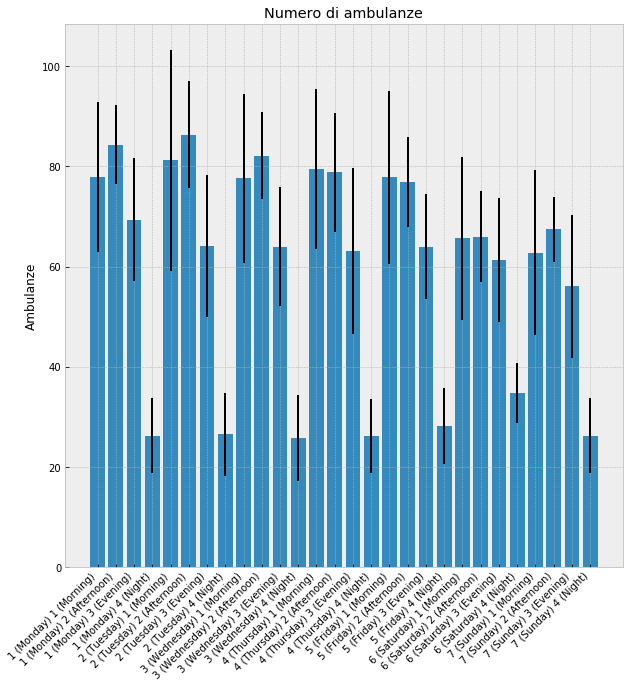

In [152]:
plt.bar(medie.index, medie.msb, yerr=std.msb)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Ambulanze')
plt.title('Numero di ambulanze')
plt.show()

Dividiamo il grafico nei codici colore. Notare che visto che dobbiamo considerare i codici colore ora stiamo parlando di _missioni_: la differenza è che ad una missione può essere assegnata più di un'ambulanza.

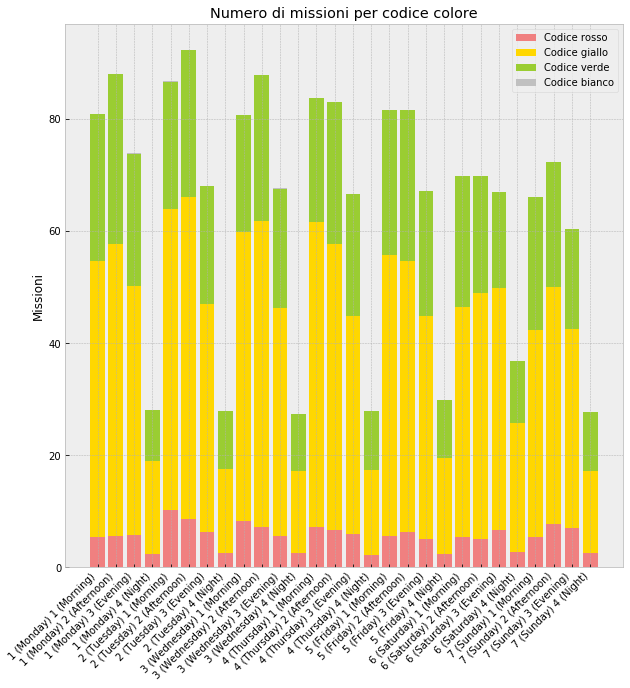

In [155]:
fig, ax = plt.subplots()
ax.bar(medie.index, medie.rosso, label = "Codice rosso", color = "#F08080")
ax.bar(medie.index, medie.giallo, label = "Codice giallo", color = "#FFD700", bottom=medie.rosso)
ax.bar(medie.index, medie.verde, label = "Codice verde", color = "#9ACD32", bottom=(medie.giallo+medie.rosso))
ax.bar(medie.index, medie.bianco, label = "Codice bianco", color = "#C0C0C0", bottom=(medie.giallo+medie.rosso+medie.verde))


ax.set_ylabel('Missioni')
ax.set_title('Numero di missioni per codice colore')
ax.legend()

plt.xticks(rotation=45, ha='right')
plt.show()

Aggiungiamo anche a questo grafico l'indicazione della deviazione standard per capire quanto il dato è variabile. La deviazione standard riguarda il totale delle missioni e non quelle legate al singolo codice colore.

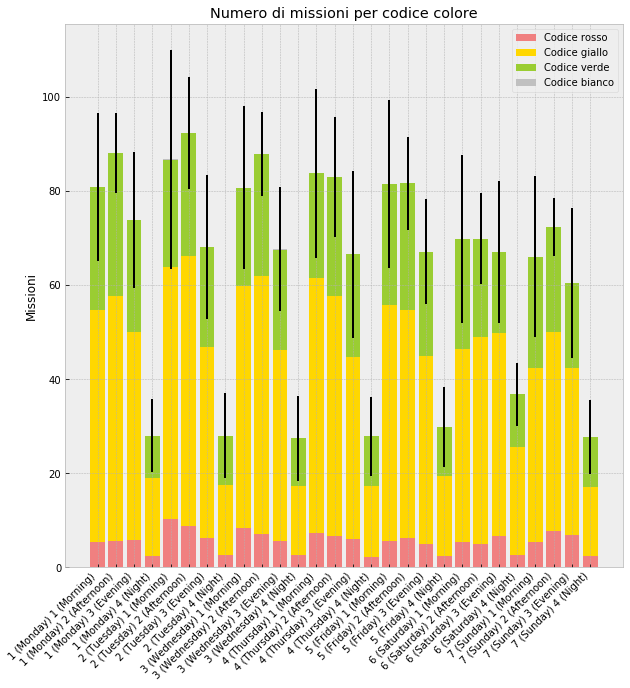

In [156]:
fig, ax = plt.subplots()
ax.bar(medie.index, medie.rosso, label = "Codice rosso", color = "#F08080")
ax.bar(medie.index, medie.giallo, label = "Codice giallo", color = "#FFD700", bottom=medie.rosso)
ax.bar(medie.index, medie.verde, label = "Codice verde", color = "#9ACD32", bottom=(medie.giallo+medie.rosso))
ax.bar(medie.index, medie.bianco, label = "Codice bianco", color = "#C0C0C0", bottom=(medie.giallo+medie.rosso+medie.verde), yerr=std.missioni)


ax.set_ylabel('Missioni')
ax.set_title('Numero di missioni per codice colore')
ax.legend()

plt.xticks(rotation=45, ha='right')
plt.show()

## Analizziamo ora per ora

Otteniamo le medie di tutti i valori per ogni orario del giorno e cerchiamo di cavarne qualche statistica interessante.

In [68]:
orari = data.groupby(by = data["hour"]).mean()
orari

,msb,msi,msa,elisoccorso,soccorso_alpino,soccorso_acqua,missioni,rosso,giallo,verde,...,guardia_medica,informazioni,consulenza,trasporto_organi,trasporto_prenotato,prestazione_ambulatoriale,da_richiamare,mezzi_altro,altro,totale_traffico_tel
hour,,,,,,,,,,,,,,,,,,,,,
00,36.184848,0.581818,1.487879,0.024242,0.0,0.0,38.281818,3.175758,22.596970,12.509091,...,0.0,0.000000,0.000000,0.675758,0.0,0.0,0.0,0.003030,0.000000,35.015152
01,33.433846,0.578462,1.769231,0.000000,0.0,0.0,35.784615,2.787692,20.950769,12.040000,...,0.0,0.000000,0.000000,0.750769,0.0,0.0,0.0,0.003077,0.000000,32.123077
02,27.274074,0.411111,1.455556,0.000000,0.0,0.0,29.177778,2.051852,15.488889,11.633333,...,0.0,0.000000,0.000000,0.851852,0.0,0.0,0.0,0.037037,0.000000,26.222222
03,23.931507,0.239726,1.232877,0.000000,0.0,0.0,25.448630,1.273973,14.551370,9.623288,...,0.0,0.000000,0.000000,0.821918,0.0,0.0,0.0,0.051370,0.000000,23.325342
04,22.277955,0.185304,1.022364,0.000000,0.0,0.0,23.479233,1.581470,13.214058,8.706070,...,0.0,0.000000,0.000000,0.824281,0.0,0.0,0.0,0.015974,0.000000,21.680511
05,22.510769,0.215385,1.040000,0.000000,0.0,0.0,23.756923,2.584615,12.649231,8.523077,...,0.0,0.000000,0.000000,0.781538,0.0,0.0,0.0,0.000000,0.000000,21.652308
06,25.278788,0.315152,1.084848,0.000000,0.0,0.0,26.654545,3.057576,14.596970,9.024242,...,0.0,0.000000,0.000000,0.830303,0.0,0.0,0.0,0.000000,0.000000,24.333333
07,30.611825,0.442159,1.092545,0.023136,0.0,0.0,32.146530,2.840617,18.552699,10.776350,...,0.0,0.000000,0.000000,0.727506,0.0,0.0,0.0,0.000000,0.000000,29.755784
08,48.638767,0.585903,1.744493,0.105727,0.0,0.0,51.074890,4.537445,29.198238,17.337004,...,0.0,0.000000,0.000000,0.689427,0.0,0.0,0.0,0.000000,0.000000,47.440529


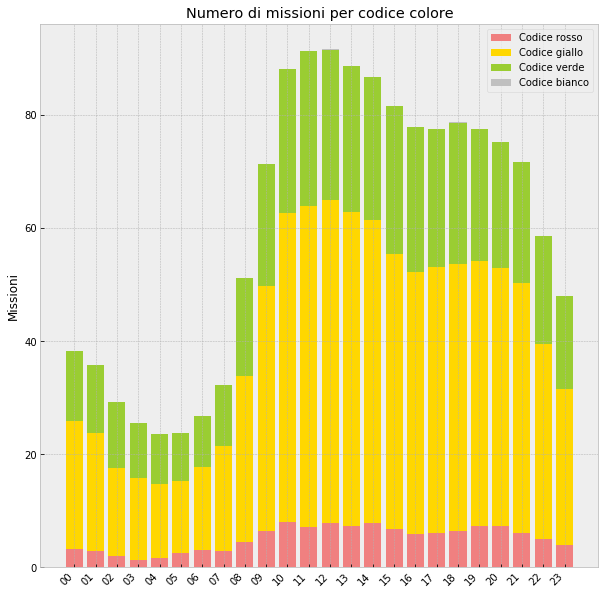

In [157]:
fig, ax = plt.subplots()
ax.bar(orari.index, orari.rosso, label = "Codice rosso", color = "#F08080")
ax.bar(orari.index, orari.giallo, label = "Codice giallo", color = "#FFD700", bottom=orari.rosso)
ax.bar(orari.index, orari.verde, label = "Codice verde", color = "#9ACD32", bottom=(orari.giallo+orari.rosso))
ax.bar(orari.index, orari.bianco, label = "Codice bianco", color = "#C0C0C0", bottom=(orari.giallo+orari.rosso+orari.verde))


ax.set_ylabel('Missioni')
ax.set_title('Numero di missioni per codice colore')
ax.legend()

plt.xticks(rotation=45, ha='right')
plt.show()

Dalla prossima visualizzazione impariamo che gli incidenti avvengono di più al ritorno da lavoro rispetto all'andata. In pausa pranzo nessuno si fa male.

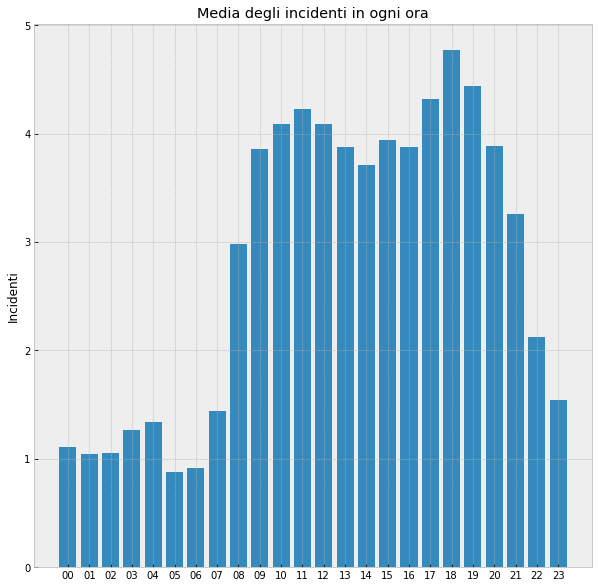

In [70]:
plt.bar(orari.index, orari.incidente_stradale)
plt.ylabel('Incidenti')
plt.title('Media degli incidenti in ogni ora')
plt.show()

È interessante vedere il prossimo grafico: i principali casi di intossicazione sono quelle etiliche (ovvero l'ubriacatura): come è normale aspettarsi la maggior parte di questi casi avvengono nelle ore notturne

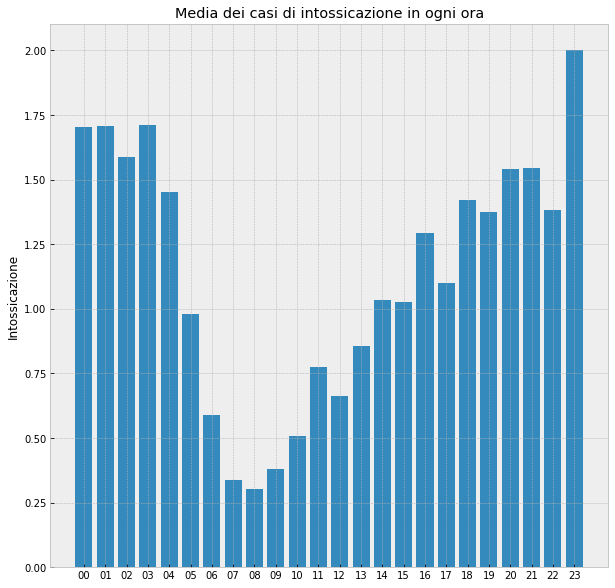

In [71]:
plt.bar(orari.index, orari.intossicazione)
plt.ylabel('Intossicazione')
plt.title('Media dei casi di intossicazione in ogni ora')
plt.show()

## Quando esce l'automedica?

Cerchiamo di capire la correlazione tra uscita dell'automedica e il tipo di evento.

[]

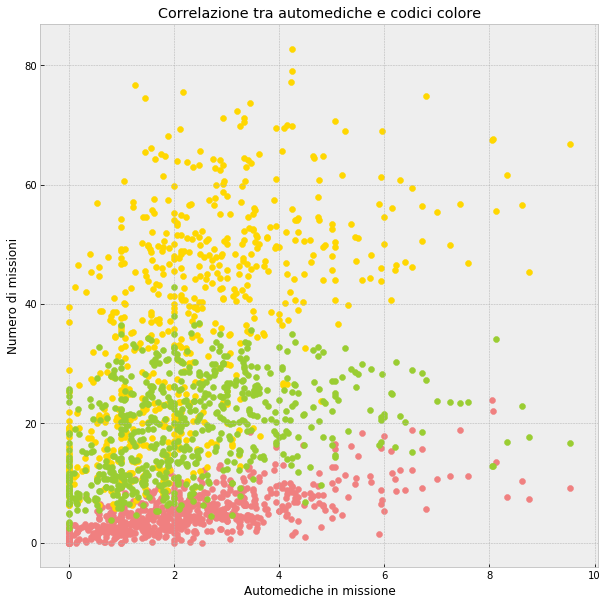

In [108]:
periodo = data
periodo["day"] = periodo.index.strftime("%Y-%m-%d")
periodo = periodo.groupby(by=["day","hour"]).mean()

plt.scatter(periodo["msa"], periodo["rosso"], color="#F08080")
plt.scatter(periodo["msa"], periodo["giallo"], color="#FFD700")
plt.scatter(periodo["msa"], periodo["verde"], color="#9ACD32")

plt.ylabel('Numero di missioni')
plt.xlabel('Automediche in missione')
plt.title('Correlazione tra automediche e codici colore')

plt.plot()

[]

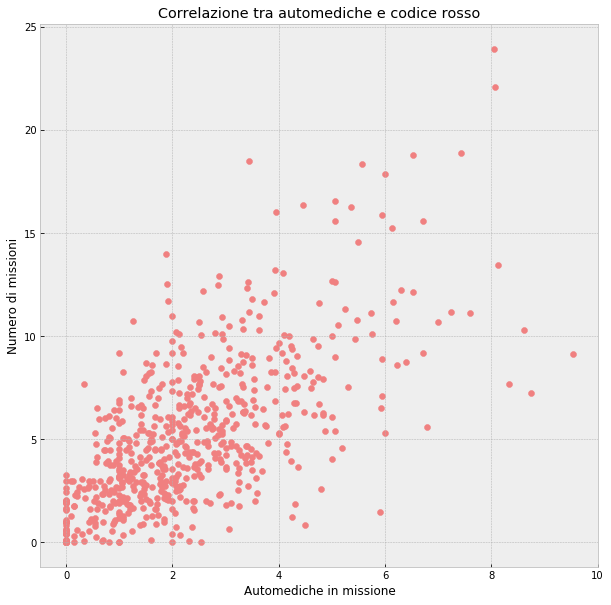

In [113]:
periodo = data
periodo["day"] = periodo.index.strftime("%Y-%m-%d")
periodo = periodo.groupby(by=["day","hour"]).mean()

plt.scatter(periodo["msa"], periodo["rosso"], color="#F08080")

plt.ylabel('Numero di missioni')
plt.xlabel('Automediche in missione')
plt.title('Correlazione tra automediche e codice rosso')

plt.plot()

# Variabilità nei giorni della settimana

Usiamo i box plot per capire la varibilità dei dati nei giorni della settimana.

/home/riccardo/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


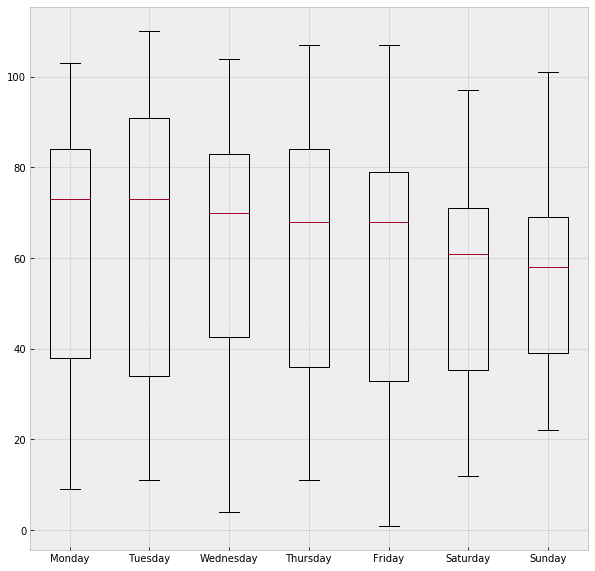

In [133]:
settimana = data.groupby(by=["weekday"]).mean()
#plt.boxplot(data[data["weekday"] == "0"]["msb"], vert=False)
fig, ax = plt.subplots()
ax.boxplot([
	data[data["weekday"] == "1"]["msb"],
	data[data["weekday"] == "2"]["msb"],
	data[data["weekday"] == "3"]["msb"],
	data[data["weekday"] == "4"]["msb"],
	data[data["weekday"] == "5"]["msb"],
	data[data["weekday"] == "6"]["msb"],
	data[data["weekday"] == "0"]["msb"],
])
ax.set_xticklabels(["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday",])
plt.show()

## Numero di missioni

Volevo plottare il numero di missioni in un giorno qualsiasi.

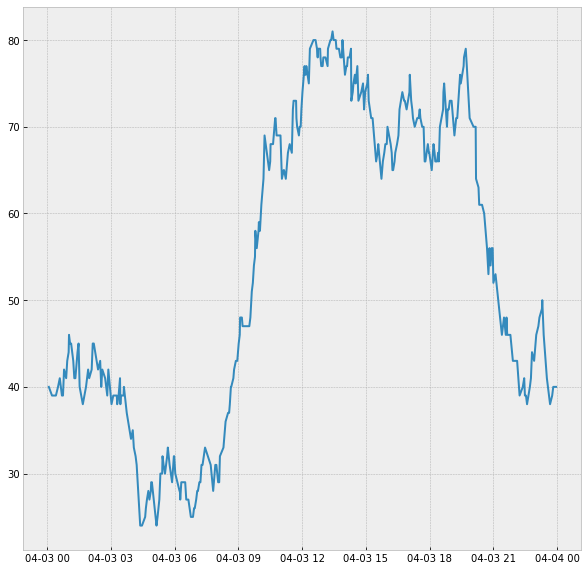

In [148]:
plt.plot(data[data["day"]=="2022-04-03"]["msb"])
plt.show()

## TODO
🌧️ Aggiungere condizioni meteo

🐙 Motivi di intervento maggiori per ora + giorno della settimana (e magari per il meteo)